# Project 3: Predicting Time through Dupont Circle (simulated) for use in Reinforcement Learning

## Harrison Blondeau, John Moroney, Mitch Rimerman

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

## Part 1: Classical Machine Learning


### Data Import and Preprocessing

Here, we load the data and transform it into a numpy array with each row being a car, and each column its state and metadata.

In [ ]:
data_single = np.load("single_state.npy", allow_pickle=True)

In [ ]:
single_df = pd.DataFrame(data_single)

In [ ]:
single_df = single_df.rename(columns={0: "Car_ID",1:"Start_Node",2:"End_Node",3:"State",4:"Steps_to_Destination"})

In [ ]:
single_df['Steps_to_Destination'].mean()

264.00417752409317

In [ ]:
single_df['Steps_to_Destination'].max()

728

<Axes: >

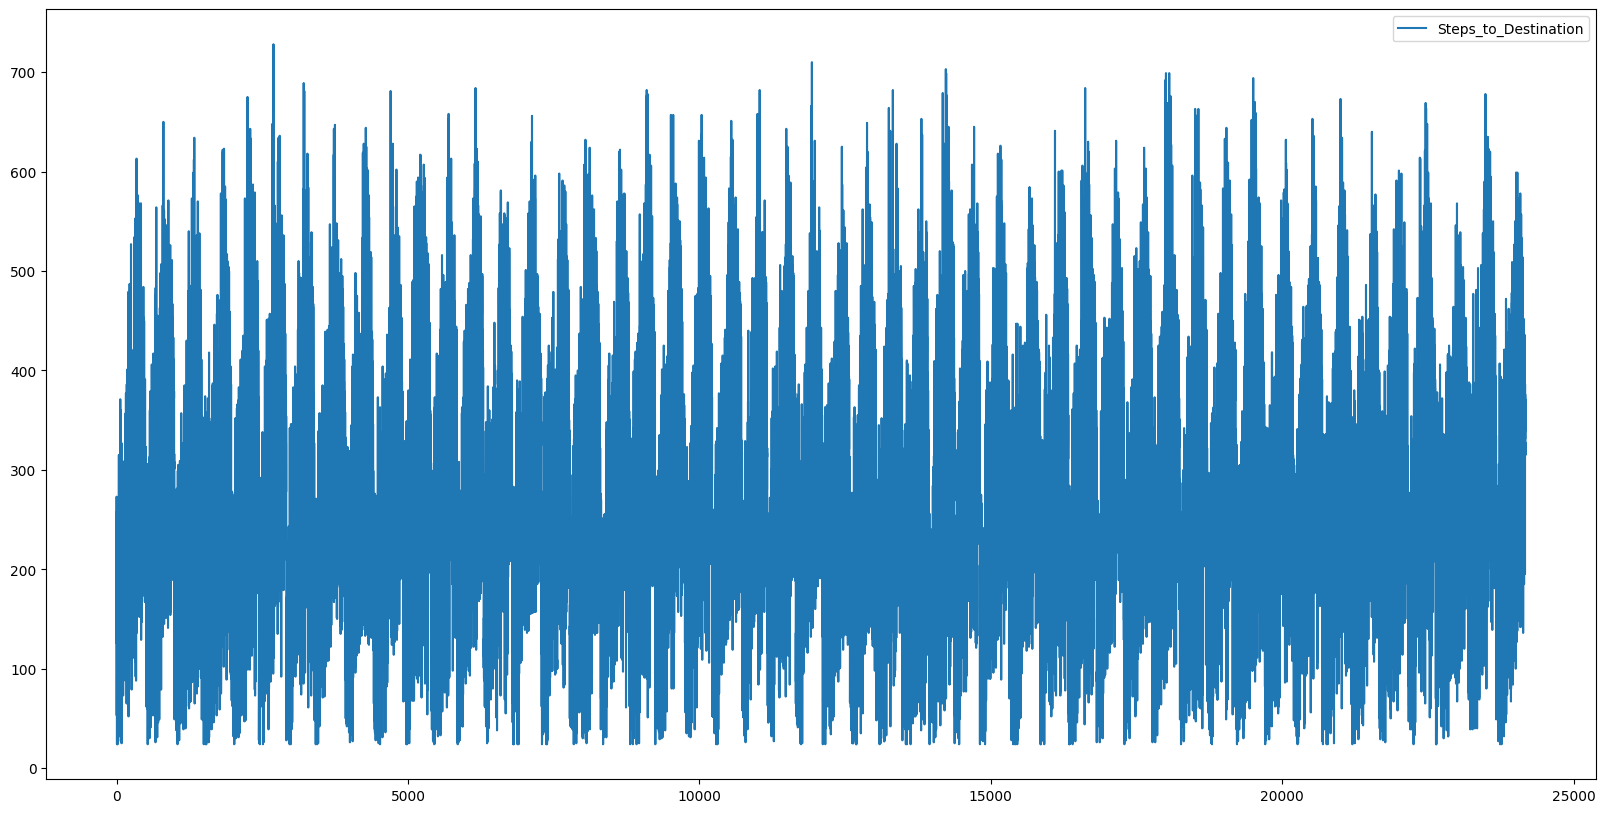

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

single_df.plot(y = 'Steps_to_Destination', ax = ax, use_index=True) 

Text(0.5, 0, 'Steps')

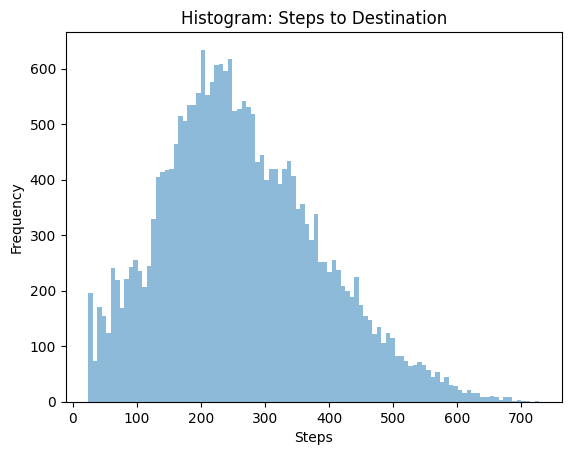

In [ ]:
ax = single_df['Steps_to_Destination'].plot.hist(bins=100, alpha=0.5,title = 'Histogram: Steps to Destination')
plt.xlabel("Steps")

In [ ]:
y = data_single[:,4]
y

array([126, 273, 114, ..., 319, 315, 327], dtype=object)

In [ ]:
state0 = np.array(data_single[:,3].tolist())
state0 = np.reshape(state0,(state0.shape[0],state0.shape[2]))
state0

array([['Y', 'R', 'G', ..., '0', '0', '0'],
       ['Y1', 'R', 'G', ..., '0', '0', '0'],
       ['Y2', 'R', 'G', ..., '0', '0', '0'],
       ...,
       ['G', 'R', 'G', ..., '24', '16', '33'],
       ['R', 'Y3', 'G', ..., '29', '21', '36'],
       ['G', 'R', 'Y1', ..., '28', '19', '35']], dtype='<U21')

In [ ]:
state0.shape

(24177, 36)

In [ ]:
X0 = np.concatenate((data_single[:,1].reshape(data_single[:,1].shape + (1,)),
                     data_single[:,2].reshape(data_single[:,2].shape + (1,)),
                     state0),axis=1)

In [ ]:
X0

array([[60, 181, 'Y', ..., '0', '0', '0'],
       [249, 226, 'Y1', ..., '0', '0', '0'],
       [121, 226, 'Y2', ..., '0', '0', '0'],
       ...,
       [226, 249, 'G', ..., '24', '16', '33'],
       [226, 249, 'R', ..., '29', '21', '36'],
       [226, 249, 'G', ..., '28', '19', '35']], dtype=object)

In [ ]:
X0.shape

(24177, 38)

Now that we have a numpy array, we must encode all of the traffic light colors and change the type of all of the elements to numeric values.

In [ ]:
def state_encoder(array):
    '''
    Encodes state
    '''
    encode_dict = {'R': [1,0,0,0,0,0,0],
                   'Y': [0,1,0,0,0,0,0],
                   'Y1':[0,0,1,0,0,0,0],
                   'Y2':[0,0,0,1,0,0,0],
                   'Y3':[0,0,0,0,1,0,0],
                   'Y4':[0,0,0,0,0,1,0],
                   'G': [0,0,0,0,0,0,1]}
    encoded_state = []
    for i in array:
        if type(i) == str:
            if i.isdigit():
              encoded_state.append(int(i))
            else:
              encoded_state += encode_dict[i]
        else:
            encoded_state.append(i)

    return encoded_state

In [ ]:
def encode_2d(array):
  '''
  Completes state encoding for 2d array
  '''
  encoded_array_list = [state_encoder(i) for i in array]
  return np.array(encoded_array_list)

In [ ]:
X0 = encode_2d(X0)

In [ ]:
X0

array([[ 60, 181,   0, ...,   0,   0,   0],
       [249, 226,   0, ...,   0,   0,   0],
       [121, 226,   0, ...,   0,   0,   0],
       ...,
       [226, 249,   0, ...,  24,  16,  33],
       [226, 249,   1, ...,  29,  21,  36],
       [226, 249,   0, ...,  28,  19,  35]])

In [ ]:
X0.shape

(24177, 110)

With the data in the correct form, we will now train-test split the data.

In [ ]:
X0_train,X0_test,y_train,y_test = train_test_split(X0, y, test_size=0.2, random_state=42)

### Algorithm Implementation

Now that we have our data in a numeric form in a 2 dimensional array, we may proceed to implement machine learning algorithms to predict time through the simulated Dupont Circle

#### Linear Regression

We will first implement a simple linear regression to gain benchmarks on the performance for our future regression models.

In [ ]:
reg = LinearRegression().fit(X0_train,y_train)

In [ ]:
reg_pred = reg.predict(X0_test)
reg_mse = mean_squared_error(y_test, reg_pred)
reg_mape = mean_absolute_percentage_error(y_test, reg_pred)

In [ ]:
print(f'Linear Regression\nMSE: {reg_mse}, MAPE: {reg_mape}')

Linear Regression
MSE: 11624.734496802677, MAPE: 0.5052586192325149


#### Random Forest

Now we will implement a random forest regression.

In [ ]:
rf = RandomForestRegressor(random_state=123).fit(X0_train,y_train)

In [ ]:
rf_pred = rf.predict(X0_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)

In [ ]:
print(f'Random Forest Regression\nMSE: {rf_mse}, MAPE: {rf_mape}')

Random Forest Regression
MSE: 1812.1142101975395, MAPE: 0.1320778878732766


#### Neural Network

We will now implement a fully connected dense neural network.

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=110, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               14208     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,577
Trainable params: 24,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X0_train.astype(float), y_train.astype(float), validation_split=.2, epochs=100)

Epoch 1/100
484/484 [==============================] - 3s 4ms/step - loss: 14984.9756 - mae: 93.1014 - val_loss: 13148.0869 - val_mae: 88.2154
Epoch 2/100
484/484 [==============================] - 2s 4ms/step - loss: 12703.5869 - mae: 87.1315 - val_loss: 12725.5342 - val_mae: 87.5223
Epoch 3/100
484/484 [==============================] - 1s 3ms/step - loss: 12128.9229 - mae: 84.6329 - val_loss: 12933.4844 - val_mae: 89.2487
Epoch 4/100
484/484 [==============================] - 1s 3ms/step - loss: 11475.4951 - mae: 81.5056 - val_loss: 11482.1680 - val_mae: 82.9310
Epoch 5/100
484/484 [==============================] - 1s 3ms/step - loss: 9192.7129 - mae: 71.0702 - val_loss: 8067.5239 - val_mae: 64.1942
Epoch 6/100
484/484 [==============================] - 1s 3ms/step - loss: 6182.0312 - mae: 58.2537 - val_loss: 5231.6143 - val_mae: 53.7325
Epoch 7/100
484/484 [==============================] - 1s 3ms/step - loss: 5087.3794 - mae: 53.1553 - val_loss: 4880.7397 - val_mae: 52.9027
Epoch

<function matplotlib.pyplot.show(close=None, block=None)>

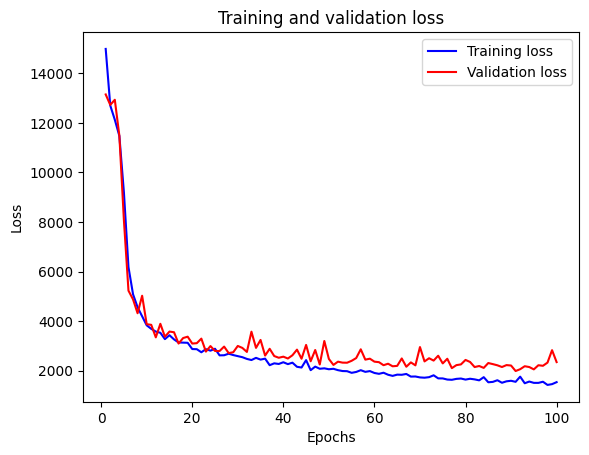

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range (1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot (epochs, val_loss, 'r', label= 'Validation loss')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

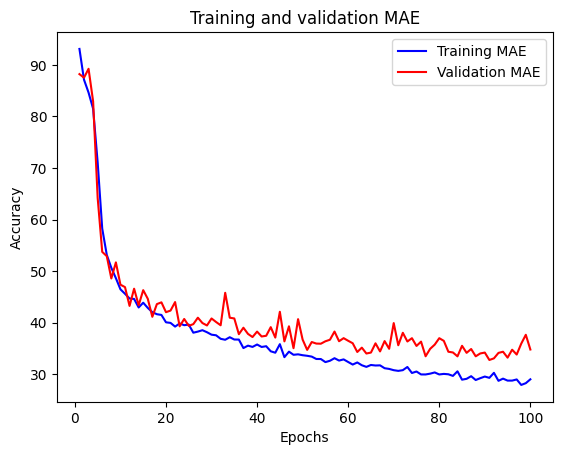

In [ ]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc,'b', label= 'Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend ()
plt.show()

In [ ]:
nn_pred = model.predict(X0_test.astype(float))
nn_mse = mean_squared_error(y_test, nn_pred)
nn_mape = mean_absolute_percentage_error(y_test, nn_pred)

152/152 [==============================] - 0s 2ms/step


In [ ]:
print(f'Neural Network\nMSE: {nn_mse}, MAPE: {nn_mape}')

Neural Network
MSE: 2533.076133294453, MAPE: 0.1472490919216147


## Part 2: Time Based Neural Network

Now we will work with multiple time steps and examine the impacts of using time-dependent data for prediction.

### Data Import and Preprocessing

Similar to prior preprocessing, here, we load the data and transform it into a 3 dimensional numpy array with the first dimension being a car, the second being a timestep, and the third each car's state and metadata at each timestep.

In [ ]:
data_full = np.load("multiple_state_array.npy", allow_pickle=True)

In [ ]:
states = np.array(data_full[:,3].tolist())

In [ ]:
states

array([[['Y', 'R', 'G', ..., '0', '0', '0'],
        ['Y1', 'R', 'G', ..., '0', '0', '0'],
        ['Y2', 'R', 'G', ..., '0', '0', '0'],
        ['Y3', 'R', 'G', ..., '0', '0', '0'],
        ['Y4', 'R', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0']],

       [['Y1', 'R', 'G', ..., '0', '0', '0'],
        ['Y2', 'R', 'G', ..., '0', '0', '0'],
        ['Y3', 'R', 'G', ..., '0', '0', '0'],
        ['Y4', 'R', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0']],

       [['Y2', 'R', 'G', ..., '0', '0', '0'],
        ['Y3', 'R', 'G', ..., '0', '0', '0'],
        ['Y4', 'R', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0'],
        ['R', 'G', 'G', ..., '0', '0', '0']],

       ...,

       [['G', 'R', 'G', ..., '24', '16', '33'],
        ['G', 'R', 'G', ..., '25', '16', '32'],
        ['G', 'R', 'G', ..., '25', '16', '33'],
        ['G', 'R

In [ ]:
states.shape

(24177, 6, 36)

In [ ]:
meta1 = data_full[:,1].reshape((24177,1))
meta1 = np.repeat(meta1, 6, axis=1)
meta1 = meta1.reshape((24177,6,1))

meta2 = data_full[:,2].reshape((24177,1))
meta2 = np.repeat(meta2, 6, axis=1)
meta2 = meta2.reshape((24177,6,1))

In [ ]:
X_full = np.concatenate((meta1,meta2,states),axis=2)

In [ ]:
X_full

array([[[60, 181, 'Y', ..., '0', '0', '0'],
        [60, 181, 'Y1', ..., '0', '0', '0'],
        [60, 181, 'Y2', ..., '0', '0', '0'],
        [60, 181, 'Y3', ..., '0', '0', '0'],
        [60, 181, 'Y4', ..., '0', '0', '0'],
        [60, 181, 'R', ..., '0', '0', '0']],

       [[249, 226, 'Y1', ..., '0', '0', '0'],
        [249, 226, 'Y2', ..., '0', '0', '0'],
        [249, 226, 'Y3', ..., '0', '0', '0'],
        [249, 226, 'Y4', ..., '0', '0', '0'],
        [249, 226, 'R', ..., '0', '0', '0'],
        [249, 226, 'R', ..., '0', '0', '0']],

       [[121, 226, 'Y2', ..., '0', '0', '0'],
        [121, 226, 'Y3', ..., '0', '0', '0'],
        [121, 226, 'Y4', ..., '0', '0', '0'],
        [121, 226, 'R', ..., '0', '0', '0'],
        [121, 226, 'R', ..., '0', '0', '0'],
        [121, 226, 'R', ..., '0', '0', '0']],

       ...,

       [[226, 249, 'G', ..., '24', '16', '33'],
        [226, 249, 'G', ..., '25', '16', '32'],
        [226, 249, 'G', ..., '25', '16', '33'],
        [226, 249, 'G'

In [ ]:
X_full.shape

(24177, 6, 38)

With the full data, we must again encode all traffic lights and convert the entire array into numeric values.

In [ ]:
def encode_3d(array):
  '''
  Completes state encoding for 3d array
  '''
  encoded_array_list = [[state_encoder(j) for j in i] for i in array]
  return np.array(encoded_array_list)

In [ ]:
X_full = encode_3d(X_full)

In [ ]:
X_full

array([[[ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   1, ...,   0,   0,   0]],

       [[249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   1, ...,   0,   0,   0],
        [249, 226,   1, ...,   0,   0,   0]],

       [[121, 226,   0, ...,   0,   0,   0],
        [121, 226,   0, ...,   0,   0,   0],
        [121, 226,   0, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0]],

       ...,

       [[226, 249,   0, ...,  24,  16,  33],
        [226, 249,   0, ...,  25,  16,  32],
        [226, 249,   0, ...,  25,  16,  33],
        [226, 249,   0, ...,  26,  1

In [ ]:
X_full.shape

(24177, 6, 110)

We will first flatten our data to be 2 dimensional for use in a neural network.

In [ ]:
X_flat = np.concatenate(np.transpose(X_full, (2, 0, 1)),axis=1)
X_flat = np.delete(X_flat, np.s_[1:6],1)
X_flat = np.delete(X_flat, np.s_[2:7],1)

In [ ]:
X_flat

array([[ 60, 181,   0, ...,   0,   0,   0],
       [249, 226,   0, ...,   0,   0,   0],
       [121, 226,   0, ...,   0,   0,   0],
       ...,
       [226, 249,   0, ...,  32,  33,  32],
       [226, 249,   1, ...,  36,  36,  35],
       [226, 249,   0, ...,  34,  35,  34]])

In [ ]:
X_flat.shape

(24177, 650)

Since our data is in a usable form, we will proceed to train-test split the data.

In [ ]:
X_flat_train,X_flat_test,y_train,y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

### Algorithm Implementation

#### Neural Network

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=650, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               83328     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 93,697
Trainable params: 93,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_flat_train.astype(float), y_train.astype(float), validation_split=.2, epochs=100)

Epoch 1/100
484/484 [==============================] - 4s 5ms/step - loss: 14638.5342 - mae: 94.5227 - val_loss: 12956.1221 - val_mae: 89.5072
Epoch 2/100
484/484 [==============================] - 2s 4ms/step - loss: 12920.1465 - mae: 89.0382 - val_loss: 12588.0713 - val_mae: 87.7287
Epoch 3/100
484/484 [==============================] - 2s 4ms/step - loss: 12455.8994 - mae: 87.7594 - val_loss: 12138.4189 - val_mae: 86.9049
Epoch 4/100
484/484 [==============================] - 2s 4ms/step - loss: 12200.7764 - mae: 86.9027 - val_loss: 12479.6484 - val_mae: 86.5093
Epoch 5/100
484/484 [==============================] - 3s 6ms/step - loss: 11872.3281 - mae: 85.4534 - val_loss: 11828.5771 - val_mae: 86.2892
Epoch 6/100
484/484 [==============================] - 2s 4ms/step - loss: 11728.0732 - mae: 84.7402 - val_loss: 11287.2588 - val_mae: 83.1156
Epoch 7/100
484/484 [==============================] - 2s 4ms/step - loss: 11535.2090 - mae: 83.6936 - val_loss: 11575.4326 - val_mae: 83.4400

<function matplotlib.pyplot.show(close=None, block=None)>

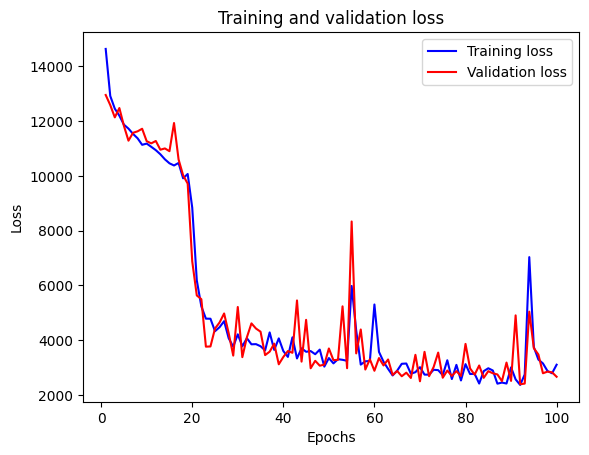

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range (1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot (epochs, val_loss, 'r', label= 'Validation loss')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt. legend()
plt.show

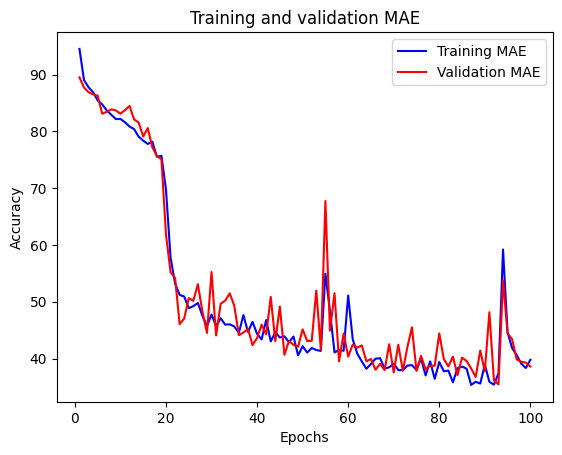

In [ ]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc,'b', label= 'Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend ()
plt.show()

In [ ]:
nn2_pred = model.predict(X_flat_test.astype(float))
nn2_mse = mean_squared_error(y_test, nn2_pred)
nn2_mape = mean_absolute_percentage_error(y_test, nn2_pred)

152/152 [==============================] - 0s 2ms/step


In [ ]:
print(f'Neural Network 2\nMSE: {nn2_mse}, MAPE: {nn2_mape}')

Neural Network 2
MSE: 2861.1958383786723, MAPE: 0.1786045568190824


## Part 3: LSTM

### Data Import and Preprocessing

Since we utilized time dependent data in the previous section and then flattened it for use in a Neural Network, we can use the same data prior to flattening.

In [ ]:
X_full

array([[[ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   0, ...,   0,   0,   0],
        [ 60, 181,   1, ...,   0,   0,   0]],

       [[249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   0, ...,   0,   0,   0],
        [249, 226,   1, ...,   0,   0,   0],
        [249, 226,   1, ...,   0,   0,   0]],

       [[121, 226,   0, ...,   0,   0,   0],
        [121, 226,   0, ...,   0,   0,   0],
        [121, 226,   0, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0],
        [121, 226,   1, ...,   0,   0,   0]],

       ...,

       [[226, 249,   0, ...,  24,  16,  33],
        [226, 249,   0, ...,  25,  16,  32],
        [226, 249,   0, ...,  25,  16,  33],
        [226, 249,   0, ...,  26,  1

In [ ]:
X_full.shape

(24177, 6, 110)

Like before, we will first train-test split the data.

In [ ]:
X_full_train,X_full_test,y_train,y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

### Algorithm Implementation

#### LSTM

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(6,110), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               122368    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_full_train.astype(float), y_train.astype(float), validation_split=.2, epochs=100)

Epoch 1/100
484/484 [==============================] - 29s 16ms/step - loss: 24137.4805 - mae: 108.0553 - val_loss: 14944.3369 - val_mae: 95.6247
Epoch 2/100
484/484 [==============================] - 9s 18ms/step - loss: 14767.6514 - mae: 94.2071 - val_loss: 14993.2148 - val_mae: 94.7045
Epoch 3/100
484/484 [==============================] - 9s 18ms/step - loss: 14053.2900 - mae: 90.9098 - val_loss: 13294.8350 - val_mae: 87.6130
Epoch 4/100
484/484 [==============================] - 7s 15ms/step - loss: 12957.7529 - mae: 87.0769 - val_loss: 12531.3623 - val_mae: 86.1462
Epoch 5/100
484/484 [==============================] - 9s 18ms/step - loss: 12744.9756 - mae: 86.4076 - val_loss: 12521.5850 - val_mae: 84.6028
Epoch 6/100
484/484 [==============================] - 10s 20ms/step - loss: 12171.8965 - mae: 84.0379 - val_loss: 12115.0674 - val_mae: 83.3221
Epoch 7/100
484/484 [==============================] - 7s 15ms/step - loss: 12154.5156 - mae: 84.2528 - val_loss: 11733.1104 - val_ma

<function matplotlib.pyplot.show(close=None, block=None)>

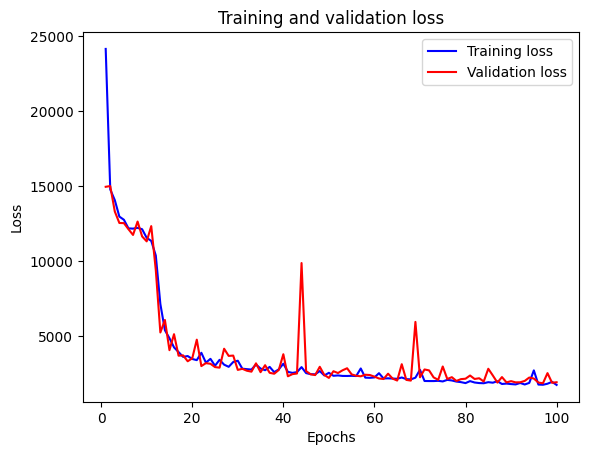

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range (1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot (epochs, val_loss, 'r', label= 'Validation loss')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt. legend()
plt.show

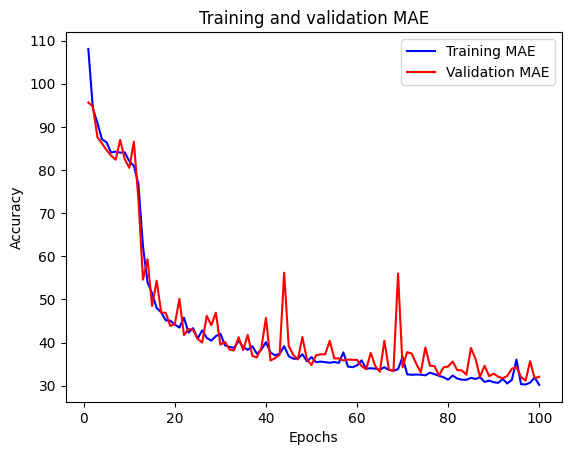

In [ ]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc,'b', label= 'Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend ()
plt.show()

In [ ]:
lstm_pred = model.predict(X_full_test.astype(float))
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)

152/152 [==============================] - 2s 8ms/step


In [ ]:
print(f'LSTM\nMSE: {lstm_mse}, MAPE: {lstm_mape}')

LSTM
MSE: 2124.5976291869483, MAPE: 0.14043039402891563
